## Step 1: sample selection

We will intersect samples with WGS and genotype array data. We also want to retrieve covariates for samples. 

In [9]:
import os
import pandas as pd
from datetime import datetime
import numpy as np
from ast import literal_eval

In [ ]:
DATASET = os.getenv('WORKSPACE_CDR')
bucket = os.getenv('WORKSPACE_BUCKET')

In [ ]:
dataset = os.getenv("WORKSPACE_CDR")
person_sql = f"""
SELECT  person.person_id,
        person.year_of_birth,
        p_race_concept.concept_name as race,
        p_gender_concept.concept_name as gender,
        p_ethnicity_concept.concept_name as ethnicity,
        p_sex_at_birth_concept.concept_name as sex_at_birth 
    FROM
        `{dataset}.person` person 
    LEFT JOIN
        `{dataset}.concept` p_race_concept 
            on person.race_concept_id = p_race_concept.CONCEPT_ID 
    LEFT JOIN
        `{dataset}.concept` p_gender_concept 
            on person.gender_concept_id = p_gender_concept.CONCEPT_ID 
    LEFT JOIN
        `{dataset}.concept` p_ethnicity_concept 
            on person.ethnicity_concept_id = p_ethnicity_concept.CONCEPT_ID 
    LEFT JOIN
        `{dataset}.concept` p_sex_at_birth_concept 
            on person.sex_at_birth_concept_id = p_sex_at_birth_concept.CONCEPT_ID  
    WHERE
        person.PERSON_ID IN (
            select
                person_id  
            from
                `{dataset}.cb_search_person` cb_search_person  
            where
                cb_search_person.person_id in (
                    select
                        person_id 
                    from
                        `{dataset}.cb_search_person` p 
                    where
                        has_whole_genome_variant = 1 and 
                        has_array_data = 1
                ) 
            )"""


allsamples = pd.read_gbq(person_sql, dialect="standard")

Using the above code, we obtained fields including: 
* person_id  
* year_of_birth
* race  
* gender  
* ethnicity  
* sex_at_birth  

In total, there are 95,562 individuals that have WGS (98,553) and genotype (165,059) data. The next step is to obtain a list of diseases, and create seperate columns for each diseases.

In [4]:
# phenotype data
binary = pd.read_csv(f"{bucket}/Pheno/0223_binary_phenotypes.csv")
quant = pd.read_csv(f"{bucket}/Pheno/0223_quant_phenotypes_combined.csv")

### Samples pre-processing: 
created two dataframes (one for quant, one for binary) that include samples that passes the filter (also have WGS + Array)

then created sample dataframes for each ancestry

In [5]:
# QC'd sample list
Samples_QCed = pd.read_csv(f"{bucket}/ArrayData/Array_Samples_QCed.tsv")

In [6]:
quant_all = allsamples.set_index('person_id').join(Array_Samples_QCed.set_index('s'), how="inner").join(quant.set_index('person_id'), how="inner")
quant_all["person_id"] = quant_all.index
binary_all = allsamples.set_index('person_id').join(Array_Samples_QCed.set_index('s'), how="inner").join(binary.set_index('person_id'), how="inner")
binary_all["person_id"] = binary_all.index

### Some data wrangling with the merged table (Continuous)

a standard practice of PGS is to use Age, Sex, top PCs  

convert race, ethnicity, gender as dummy variables

also convert bracket to seperate columns so that they are easier for Hail to parse

In [7]:
# age 
quant_all.loc[:,"Age"] = 2023 - quant_all.year_of_birth

# sex_at_birth: 
# 'Intersex', 'I prefer not to answer', 'None', 'No matching concept', 'PMI: Skip', 'Male', 'Female'
quant_all.loc[:,"is_sex_Male"] = (quant_all.sex_at_birth == "Male") * 1
quant_all.loc[:,"is_sex_Female"] = (quant_all.sex_at_birth == "Female") * 1

# race 
# 'None of these', 'None Indicated', 'White', 'Black or African American', 'More than one population',
# 'I prefer not to answer', 'PMI: Skip', 'Native Hawaiian or Other Pacific Islander', 
# 'Asian','Middle Eastern or North African'

quant_all.loc[:,"is_White"] = (quant_all.race == "White") * 1
quant_all.loc[:,"is_Black_or_African_American"] = (quant_all.race == "Black or African American") * 1
quant_all.loc[:,"is_Native_Hawaiian_or_Other_Pacific_Islander"] = (quant_all.race == "Native Hawaiian or Other Pacific Islander") * 1
quant_all.loc[:,"is_Asian"] = (quant_all.race == "Asian") * 1
quant_all.loc[:,"is_Middle_Eastern_or_North_African"] = (quant_all.race == "Middle Eastern or North African") * 1

# gender: 
# 'Gender Identity: Non Binary', 'PMI: Skip', 'Male', 'Female',
# 'Not man only, not woman only, prefer not to answer, or skipped',
#  'Gender Identity: Transgender', 'Gender Identity: Additional Options', 'I prefer not to answer'
quant_all.loc[:,"is_gender_Male"] = (quant_all.gender == "Male") * 1
quant_all.loc[:,"is_gender_Female"] = (quant_all.gender == "Female") * 1

# ethnicity
# 'What Race Ethnicity: Race Ethnicity None Of These', 'Hispanic or Latino', 'Not Hispanic or Latino',
# 'PMI: Prefer Not To Answer', 'PMI: Skip'
quant_all.loc[:,"is_Hispanic"] = (quant_all.ethnicity == "Hispanic or Latino") * 1

# ancestry_pred_other
# 'eur', 'amr', 'afr', 'oth', 'sas', 'eas', 'mid'
quant_all.loc[:,"is_anc_pred_eur"] = (quant_all.ancestry_pred_other == "eur") * 1
quant_all.loc[:,"is_anc_pred_amr"] = (quant_all.ancestry_pred_other == "amr") * 1
quant_all.loc[:,"is_anc_pred_afr"] = (quant_all.ancestry_pred_other == "afr") * 1
quant_all.loc[:,"is_anc_pred_oth"] = (quant_all.ancestry_pred_other == "oth") * 1
quant_all.loc[:,"is_anc_pred_sas"] = (quant_all.ancestry_pred_other == "sas") * 1
quant_all.loc[:,"is_anc_pred_eas"] = (quant_all.ancestry_pred_other == "eas") * 1
quant_all.loc[:,"is_anc_pred_mid"] = (quant_all.ancestry_pred_other == "mid") * 1

# parse pca_features into seperate columns 
quant_all.loc[:, "PC_lst"] = quant_all.pca_features.apply(literal_eval).tolist()
quant_pcs = quant_all.PC_lst.apply(pd.Series)
quant_pcs.columns = ["PC" + str(i) for i in range(1,17)]
quant_all = pd.concat([quant_all, quant_pcs], axis=1)

In [8]:
# create bins for each ancestry
# 'eur', 'amr', 'afr', 'oth', 'sas', 'eas', 'mid'
quant_all.loc[quant_all.is_anc_pred_eur == 1, "eur_bin"] = np.random.randint(1, 11, sum(quant_all.is_anc_pred_eur == 1))
quant_all.loc[quant_all.is_anc_pred_amr == 1, "amr_bin"] = np.random.randint(1, 11, sum(quant_all.is_anc_pred_amr == 1))
quant_all.loc[quant_all.is_anc_pred_afr == 1, "afr_bin"] = np.random.randint(1, 11, sum(quant_all.is_anc_pred_afr == 1))
quant_all.loc[quant_all.is_anc_pred_oth == 1, "oth_bin"] = np.random.randint(1, 11, sum(quant_all.is_anc_pred_oth == 1))
quant_all.loc[quant_all.is_anc_pred_sas == 1, "sas_bin"] = np.random.randint(1, 11, sum(quant_all.is_anc_pred_sas == 1))
quant_all.loc[quant_all.is_anc_pred_eas == 1, "eas_bin"] = np.random.randint(1, 11, sum(quant_all.is_anc_pred_eas == 1))
quant_all.loc[quant_all.is_anc_pred_mid == 1, "mid_bin"] = np.random.randint(1, 11, sum(quant_all.is_anc_pred_mid == 1))

quant_all.eur_bin = quant_all.eur_bin.astype("Int64")
quant_all.amr_bin = quant_all.amr_bin.astype("Int64")
quant_all.afr_bin = quant_all.afr_bin.astype("Int64")
quant_all.oth_bin = quant_all.oth_bin.astype("Int64")
quant_all.sas_bin = quant_all.sas_bin.astype("Int64")
quant_all.eas_bin = quant_all.eas_bin.astype("Int64")
quant_all.mid_bin = quant_all.mid_bin.astype("Int64")

In [9]:
quant_all = quant_all.loc[:,["person_id", 'Age', 'is_sex_Male', 'is_sex_Female',
       'is_White', 'is_Black_or_African_American',
       'is_Native_Hawaiian_or_Other_Pacific_Islander', 'is_Asian',
       'is_Middle_Eastern_or_North_African', 'is_gender_Male',
       'is_gender_Female', 'is_Hispanic', 'is_anc_pred_eur', 'is_anc_pred_amr',
       'is_anc_pred_afr', 'is_anc_pred_sas', 'is_anc_pred_eas',
       'is_anc_pred_mid', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6',
       'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15',
       'PC16', 'BMI', 'Height', 'DBP', 'SBP', 'HbA1c',
       'leukocyte', 'Lymphocyte', 'RBC', 'Neutrophil',
       'Hemoglobin_concentration', 'hematocrit_percentage', 'Eosinophil',
       'Platelet', 'Monocyte', 'MCV', 'MCH', 'Basophil', 'MCHC', 'HDL', 'LDL',
       'TC', 'TG', "eur_bin", "amr_bin", "afr_bin", "oth_bin", "sas_bin", "eas_bin", "mid_bin"]]

In [10]:
quant_all.to_csv(f"{bucket}/Pheno/quant_all.tsv", 
                 sep = "\t", index=False)

## Some data wrangling with the merged table (Binary)
a standard practice of PGS is to use Age, Sex, top PCs

convert race, ethnicity, gender as dummy variables

also convert bracket to seperate columns so that they are easier for Hail to parse

In [12]:
binary_all.columns

Index(['year_of_birth', 'race', 'gender', 'ethnicity', 'sex_at_birth',
       'ancestry_pred', 'probabilities', 'pca_features', 'ancestry_pred_other',
       'gender_concept_id', 'race_concept_id', 'birth_datetime', 'Asthma',
       'Asthma_DATE', 'Breast_Cancer', 'Breast_Cancer_DATE', 'CHD', 'CHD_DATE',
       'Colorectal_Cancer', 'Colorectal_Cancer_DATE', 'Y', 'Depression_DATE',
       'Prostate_Cancer', 'Prostate_Cancer_DATE', 'T2D', 'T2D_DATE', 'T1D',
       'T1D_DATE', 'person_id'],
      dtype='object')

In [13]:
# age 
binary_all.loc[:,"Age"] = 2023 - binary_all.year_of_birth

# sex_at_birth: 
# 'Intersex', 'I prefer not to answer', 'None', 'No matching concept', 'PMI: Skip', 'Male', 'Female'
binary_all.loc[:,"is_sex_Male"] = (binary_all.sex_at_birth == "Male") * 1
binary_all.loc[:,"is_sex_Female"] = (binary_all.sex_at_birth == "Female") * 1

# race 
# 'None of these', 'None Indicated', 'White', 'Black or African American', 'More than one population',
# 'I prefer not to answer', 'PMI: Skip', 'Native Hawaiian or Other Pacific Islander', 
# 'Asian','Middle Eastern or North African'

binary_all.loc[:,"is_White"] = (binary_all.race == "White") * 1
binary_all.loc[:,"is_Black_or_African_American"] = (binary_all.race == "Black or African American") * 1
binary_all.loc[:,"is_Native_Hawaiian_or_Other_Pacific_Islander"] = (binary_all.race == "Native Hawaiian or Other Pacific Islander") * 1
binary_all.loc[:,"is_Asian"] = (binary_all.race == "Asian") * 1
binary_all.loc[:,"is_Middle_Eastern_or_North_African"] = (binary_all.race == "Middle Eastern or North African") * 1

# gender: 
# 'Gender Identity: Non Binary', 'PMI: Skip', 'Male', 'Female',
# 'Not man only, not woman only, prefer not to answer, or skipped',
#  'Gender Identity: Transgender', 'Gender Identity: Additional Options', 'I prefer not to answer'
binary_all.loc[:,"is_gender_Male"] = (binary_all.gender == "Male") * 1
binary_all.loc[:,"is_gender_Female"] = (binary_all.gender == "Female") * 1

# ethnicity
# 'What Race Ethnicity: Race Ethnicity None Of These', 'Hispanic or Latino', 'Not Hispanic or Latino',
# 'PMI: Prefer Not To Answer', 'PMI: Skip'
binary_all.loc[:,"is_Hispanic"] = (binary_all.ethnicity == "Hispanic or Latino") * 1

# ancestry_pred_other
# 'eur', 'amr', 'afr', 'oth', 'sas', 'eas', 'mid'
binary_all.loc[:,"is_anc_pred_eur"] = (binary_all.ancestry_pred_other == "eur") * 1
binary_all.loc[:,"is_anc_pred_amr"] = (binary_all.ancestry_pred_other == "amr") * 1
binary_all.loc[:,"is_anc_pred_afr"] = (binary_all.ancestry_pred_other == "afr") * 1
binary_all.loc[:,"is_anc_pred_oth"] = (binary_all.ancestry_pred_other == "oth") * 1
binary_all.loc[:,"is_anc_pred_sas"] = (binary_all.ancestry_pred_other == "sas") * 1
binary_all.loc[:,"is_anc_pred_eas"] = (binary_all.ancestry_pred_other == "eas") * 1
binary_all.loc[:,"is_anc_pred_mid"] = (binary_all.ancestry_pred_other == "mid") * 1

# parse pca_features into seperate columns 
binary_all.loc[:, "PC_lst"] = binary_all.pca_features.apply(literal_eval).tolist()
binary_pcs = binary_all.PC_lst.apply(pd.Series)
binary_pcs.columns = ["PC" + str(i) for i in range(1,17)]
binary_all = pd.concat([binary_all, binary_pcs], axis=1)

In [14]:
# create bins for each ancestry
# 'eur', 'amr', 'afr', 'oth', 'sas', 'eas', 'mid'
binary_all.loc[binary_all.is_anc_pred_eur == 1, "eur_bin"] = np.random.randint(1, 11, sum(binary_all.is_anc_pred_eur == 1))
binary_all.loc[binary_all.is_anc_pred_amr == 1, "amr_bin"] = np.random.randint(1, 11, sum(binary_all.is_anc_pred_amr == 1))
binary_all.loc[binary_all.is_anc_pred_afr == 1, "afr_bin"] = np.random.randint(1, 11, sum(binary_all.is_anc_pred_afr == 1))
binary_all.loc[binary_all.is_anc_pred_oth == 1, "oth_bin"] = np.random.randint(1, 11, sum(binary_all.is_anc_pred_oth == 1))
binary_all.loc[binary_all.is_anc_pred_sas == 1, "sas_bin"] = np.random.randint(1, 11, sum(binary_all.is_anc_pred_sas == 1))
binary_all.loc[binary_all.is_anc_pred_eas == 1, "eas_bin"] = np.random.randint(1, 11, sum(binary_all.is_anc_pred_eas == 1))
binary_all.loc[binary_all.is_anc_pred_mid == 1, "mid_bin"] = np.random.randint(1, 11, sum(binary_all.is_anc_pred_mid == 1))

binary_all.eur_bin = binary_all.eur_bin.astype("Int64")
binary_all.amr_bin = binary_all.amr_bin.astype("Int64")
binary_all.afr_bin = binary_all.afr_bin.astype("Int64")
binary_all.oth_bin = binary_all.oth_bin.astype("Int64")
binary_all.sas_bin = binary_all.sas_bin.astype("Int64")
binary_all.eas_bin = binary_all.eas_bin.astype("Int64")
binary_all.mid_bin = binary_all.mid_bin.astype("Int64")

In [15]:
binary_all = binary_all.loc[:,["person_id", 'Age', 'is_sex_Male', 'is_sex_Female',
       'is_White', 'is_Black_or_African_American',
       'is_Native_Hawaiian_or_Other_Pacific_Islander', 'is_Asian',
       'is_Middle_Eastern_or_North_African', 'is_gender_Male',
       'is_gender_Female', 'is_Hispanic', 'is_anc_pred_eur', 'is_anc_pred_amr',
       'is_anc_pred_afr', 'is_anc_pred_sas', 'is_anc_pred_eas',
       'is_anc_pred_mid', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6',
       'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15',
       'PC16', 'Asthma','Breast_Cancer', 'CHD',
       'Colorectal_Cancer','Prostate_Cancer', 'T2D','T1D',
       "eur_bin", "amr_bin", "afr_bin", "oth_bin", "sas_bin", "eas_bin", "mid_bin"]]

In [17]:
binary_all.to_csv(f"{bucket}/Pheno/binary_all.tsv", 
                 sep = "\t", index=False)

### Quick visualization 

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

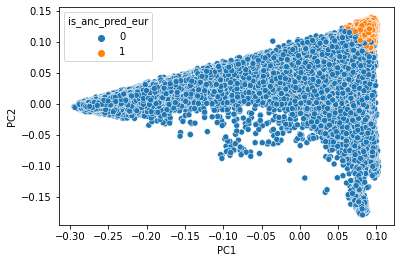

In [29]:
sns.scatterplot(data=binary_all, x="PC1", y="PC2", hue="is_anc_pred_eur")